In [217]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

In [218]:
ticker = "INFY.NS"
# ticker='TCS.NS'
company = yf.Ticker(ticker)
sp500 = company.history(period="max")  # You can change the period as needed
company_info = company.info
print("Type of company_info:", type(company_info))

# company_full_name = company_info.get('longName', 'Name not found')

company_full_name = company_info.get('longName', 'Name not found')
print("Company Full Name:", company_full_name)


Type of company_info: <class 'dict'>
Company Full Name: Infosys Limited


In [219]:

sp500.index

DatetimeIndex(['1996-01-01 00:00:00+05:30', '1996-01-02 00:00:00+05:30',
               '1996-01-03 00:00:00+05:30', '1996-01-04 00:00:00+05:30',
               '1996-01-05 00:00:00+05:30', '1996-01-08 00:00:00+05:30',
               '1996-01-09 00:00:00+05:30', '1996-01-10 00:00:00+05:30',
               '1996-01-11 00:00:00+05:30', '1996-01-12 00:00:00+05:30',
               ...
               '2024-06-07 00:00:00+05:30', '2024-06-10 00:00:00+05:30',
               '2024-06-11 00:00:00+05:30', '2024-06-12 00:00:00+05:30',
               '2024-06-13 00:00:00+05:30', '2024-06-14 00:00:00+05:30',
               '2024-06-18 00:00:00+05:30', '2024-06-19 00:00:00+05:30',
               '2024-06-20 00:00:00+05:30', '2024-06-21 00:00:00+05:30'],
              dtype='datetime64[ns, Asia/Kolkata]', name='Date', length=7153, freq=None)

In [220]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

<Axes: xlabel='Date'>

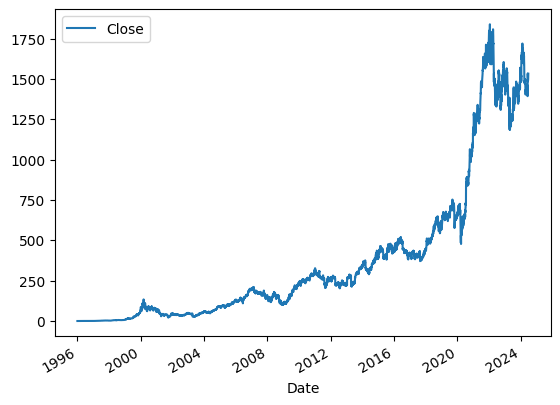

In [221]:
sp500.plot.line(y='Close', use_index=True)

In [222]:
sp500=sp500.drop(columns=['Dividends', 'Stock Splits'])

In [223]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

### We took the shift Column and we took the price back 1 day.

In [224]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [225]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1996-01-01 00:00:00+05:30,0.520704,0.521856,0.518145,0.521856,204800,0.519745
1996-01-02 00:00:00+05:30,0.520704,0.523263,0.519745,0.519745,204800,0.523263
1996-01-03 00:00:00+05:30,0.523263,0.523263,0.523263,0.523263,102400,0.519809
1996-01-04 00:00:00+05:30,0.518146,0.520704,0.518146,0.519809,307200,0.513668
1996-01-05 00:00:00+05:30,0.513668,0.513668,0.513668,0.513668,51200,0.516866
...,...,...,...,...,...,...
2024-06-14 00:00:00+05:30,1503.699951,1503.699951,1486.050049,1488.900024,4237727,1498.199951
2024-06-18 00:00:00+05:30,1497.000000,1507.000000,1495.400024,1498.199951,5420939,1511.349976
2024-06-19 00:00:00+05:30,1505.000000,1515.650024,1496.699951,1511.349976,5493456,1515.400024


In [226]:
sp500['Target'] = (sp500["Tomorrow"] > sp500['Close']).astype(int)

In [227]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1996-01-01 00:00:00+05:30,0.520704,0.521856,0.518145,0.521856,204800,0.519745,0
1996-01-02 00:00:00+05:30,0.520704,0.523263,0.519745,0.519745,204800,0.523263,1
1996-01-03 00:00:00+05:30,0.523263,0.523263,0.523263,0.523263,102400,0.519809,0
1996-01-04 00:00:00+05:30,0.518146,0.520704,0.518146,0.519809,307200,0.513668,0
1996-01-05 00:00:00+05:30,0.513668,0.513668,0.513668,0.513668,51200,0.516866,1
...,...,...,...,...,...,...,...
2024-06-14 00:00:00+05:30,1503.699951,1503.699951,1486.050049,1488.900024,4237727,1498.199951,1
2024-06-18 00:00:00+05:30,1497.000000,1507.000000,1495.400024,1498.199951,5420939,1511.349976,1
2024-06-19 00:00:00+05:30,1505.000000,1515.650024,1496.699951,1511.349976,5493456,1515.400024,1


In [228]:
sp500 = sp500.loc['1990-01-01':].copy()
sp500 = sp500.loc[:'2022-05-18'].copy()

In [229]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1996-01-01 00:00:00+05:30,0.520704,0.521856,0.518145,0.521856,204800,0.519745,0
1996-01-02 00:00:00+05:30,0.520704,0.523263,0.519745,0.519745,204800,0.523263,1
1996-01-03 00:00:00+05:30,0.523263,0.523263,0.523263,0.523263,102400,0.519809,0
1996-01-04 00:00:00+05:30,0.518146,0.520704,0.518146,0.519809,307200,0.513668,0
1996-01-05 00:00:00+05:30,0.513668,0.513668,0.513668,0.513668,51200,0.516866,1
...,...,...,...,...,...,...,...
2022-05-12 00:00:00+05:30,1435.508491,1448.308600,1426.311422,1430.578125,7034979,1426.406250,0
2022-05-13 00:00:00+05:30,1440.533801,1449.967909,1420.432819,1426.406250,6723761,1411.899414,0
2022-05-16 00:00:00+05:30,1431.715902,1433.469968,1401.991228,1411.899414,6145331,1439.727661,1


## Random forest Classifier

In [230]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [231]:
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

In [232]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow', 'Target'], dtype='object')

In [233]:
features=['Close','Volume','Open','High','Low']

# Extract features and target for training
X_train = train[features]
y_train = train['Target']

# Extract features and target for testing
X_test = test[features]
y_test = test['Target']

In [234]:


model.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=100, random_state=1)

### Predict Data

In [235]:
from sklearn.metrics import precision_score

preds = model.predict(test[features])

In [236]:
preds = pd.Series(preds,index=test.index)


In [237]:
preds

Date
2021-12-22 00:00:00+05:30    0
2021-12-23 00:00:00+05:30    0
2021-12-24 00:00:00+05:30    0
2021-12-27 00:00:00+05:30    0
2021-12-28 00:00:00+05:30    0
                            ..
2022-05-12 00:00:00+05:30    1
2022-05-13 00:00:00+05:30    1
2022-05-16 00:00:00+05:30    1
2022-05-17 00:00:00+05:30    1
2022-05-18 00:00:00+05:30    1
Length: 100, dtype: int64

In [238]:
precision_score(y_test,preds)

np.float64(0.48148148148148145)

In [239]:
combined = pd.concat([y_test,preds],axis=1)


<Axes: xlabel='Date'>

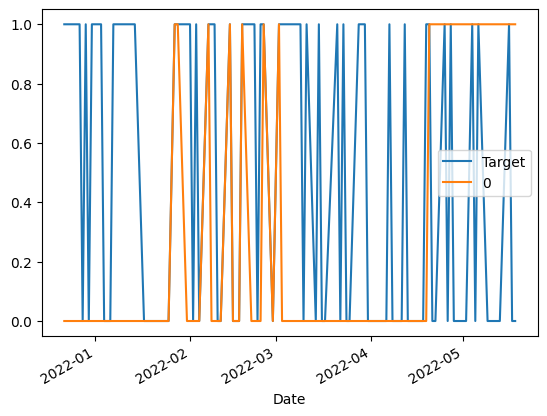

In [240]:
combined.plot()

In [241]:
def predict(train, test, features, model):
    model.fit(train[features], train['Target'])
    preds = model.predict(test[features])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [242]:
def backtest(data, model, features, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, features, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [243]:
predictions = backtest(sp500, model, features)

In [244]:
predictions['Predictions'].value_counts()

Predictions
0    2423
1    1714
Name: count, dtype: int64

In [245]:
precision_score(predictions['Target'], predictions['Predictions'])

np.float64(0.5204200700116686)

In [246]:
predictions['Target'].value_counts()/predictions.shape[0]

Target
1    0.518492
0    0.481508
Name: count, dtype: float64

#### Mean of closed price of several days and years

In [247]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    # sp500[ratio_columns] = sp500['Close']/rolling_averages["Close"]
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

    new_predictors += [ratio_column, trend_column]
    
    

In [248]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00+05:30,0.520704,0.521856,0.518145,0.521856,204800,0.519745,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-02 00:00:00+05:30,0.520704,0.523263,0.519745,0.519745,204800,0.523263,1,0.997974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03 00:00:00+05:30,0.523263,0.523263,0.523263,0.523263,102400,0.519809,0,1.003373,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04 00:00:00+05:30,0.518146,0.520704,0.518146,0.519809,307200,0.513668,0,0.996688,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05 00:00:00+05:30,0.513668,0.513668,0.513668,0.513668,51200,0.516866,1,0.994058,0.0,0.988454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12 00:00:00+05:30,1435.508491,1448.308600,1426.311422,1430.578125,7034979,1426.406250,0,0.994087,0.0,0.979518,1.0,0.873034,27.0,0.901049,136.0,1.485486,546.0
2022-05-13 00:00:00+05:30,1440.533801,1449.967909,1420.432819,1426.406250,6723761,1411.899414,0,0.998540,0.0,0.981562,1.0,0.872313,27.0,0.897994,136.0,1.479727,546.0
2022-05-16 00:00:00+05:30,1431.715902,1433.469968,1401.991228,1411.899414,6145331,1439.727661,1,0.994889,0.0,0.981990,0.0,0.865056,27.0,0.888463,136.0,1.463295,545.0


In [249]:
sp500  = sp500.dropna()

In [250]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1999-11-01 00:00:00+05:30,36.907763,38.209165,34.357015,34.674557,17923456,37.448624,1,0.976804,0.0,0.922746,1.0,1.006858,28.0,1.799186,125.0,5.033877,493.0
1999-11-02 00:00:00+05:30,34.461126,37.448624,34.357014,37.448624,11051648,38.971001,1,1.038463,1.0,1.006295,1.0,1.081521,29.0,1.930603,125.0,5.407611,494.0
1999-11-03 00:00:00+05:30,38.359601,39.692758,37.616501,38.971001,21494272,39.533459,1,1.019921,2.0,1.048779,2.0,1.119297,29.0,1.995643,125.0,5.596374,494.0
1999-11-04 00:00:00+05:30,39.276302,39.666723,38.781770,39.533459,10679296,41.360378,1,1.007165,2.0,1.057333,3.0,1.129383,29.0,2.010719,126.0,5.645515,495.0
1999-11-05 00:00:00+05:30,39.661528,41.773441,39.567827,41.360378,21151104,41.360378,0,1.022584,2.0,1.077160,4.0,1.174315,29.0,2.088703,126.0,5.872153,496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12 00:00:00+05:30,1435.508491,1448.308600,1426.311422,1430.578125,7034979,1426.406250,0,0.994087,0.0,0.979518,1.0,0.873034,27.0,0.901049,136.0,1.485486,546.0
2022-05-13 00:00:00+05:30,1440.533801,1449.967909,1420.432819,1426.406250,6723761,1411.899414,0,0.998540,0.0,0.981562,1.0,0.872313,27.0,0.897994,136.0,1.479727,546.0
2022-05-16 00:00:00+05:30,1431.715902,1433.469968,1401.991228,1411.899414,6145331,1439.727661,1,0.994889,0.0,0.981990,0.0,0.865056,27.0,0.888463,136.0,1.463295,545.0


In [251]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [252]:
def predict(train, test, features, model):
    model.fit(train[features], train['Target'])
    preds = model.predict_proba(test[features])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [253]:
predictions = backtest(sp500,model,new_predictors)

In [254]:
predictions['Predictions'].value_counts()

Predictions
0.0    2985
1.0     152
Name: count, dtype: int64

In [255]:
precision_score(predictions['Target'],predictions['Predictions'])


np.float64(0.5460526315789473)

In [256]:
sp500.to_csv(f'data/{company_full_name}.csv')